# Image description generation with Keras and TensorFlow

This notebook presents a deep neural network, which tackles the image-description generation problem, using the keras and
TensorFlow libraries. The model uses transfer learning to speed up its learning process. It uses transfer learning in
the following two forms:

1. Pre trained WordNet Weights for the InceptionV3 CNN
2. Common word embeddings from Glove

The model follows an encoder/decoder architecture that uses the InceptionV3 CNN for the computer vision part, to extract
visual features that may be present within images. Then it uses a LSTM RNN for the language modeling part, to generate
sentences (captions) for those images. Glove contains a collection of vectors for common words. Glove organises its
vectors in such a way that allows similar words to be close to each other in euclidean space.

Since pre-trained weights from ImageNet are used for InceptionV3, the model assumes that all visual training was
previously performed. This means that the model only trains on the textual data present in the Flickr 8k dataset.

## Importing the necessary libraries

Before we build the model, we must first import the necessary libraries.

In [1]:
# Importing the necessary libraries
import glob
import os
import pickle
import ssl
import string
from time import strftime
from time import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.applications.inception_v3
import tensorflow.keras.applications.mobilenet
import tensorflow.keras.preprocessing.image
from PIL import Image
from tensorflow.keras import Input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

from postprocessing.metrics import BLEU
from postprocessing.metrics import CIDEr
from postprocessing.metrics import METEOR
from postprocessing.metrics import ROUGE_N
from postprocessing.metrics import SPICE

from models.keras.captioning.inception_v3_lstm import I

We then declare some constant variables to hold the start and stop tokens, number of epochs, and content paths.

In [2]:
# The start and stop tokens.
START = "<START>"
STOP = "<END>"

# The width, heights of imput images to the encoder and the ouput dimensions.
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048

# The number of training epochs
NUM_EPOCHS = 100

# The directory containing the data set files.
data_root = "../../../datasets/image_captioning/flickr_8k"

images_folder = ''

def format_time(time):
    h = int(time / (60 * 60))
    m = int((time % (60 * 60)) / 60)
    s = time % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

## The Data

The data for any image captioning task is has two parts: the images and the captions. For this particular example, we
use the Flickr 8k data set.

1. [Flickr 8k Images](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip)
2. [Flickr 8k Text](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip)

The dataset was compiled in 2013, and consisted of 8,000 images, each paired with up to five different captions. These
captions provided clear descriptions of the salient entities in the images.

The authors opted to use crowdsourcing to collect large numbers of descriptive captions for many images. They mainly
focused on conceptual image descriptions. Conceptual image descriptions identify what was depicted in the image. While
they may be abstract, image understanding is mostly interested in concrete descriptions of the depicted scenes and
entities, their attributes and relations, as well as the events they participated.

It was argued that images with associated text available online were unsuitable for the image description task. This
was because the authors of the images were often attempted to illustrate stories that may have a little direct
connection to the image. Moreover, when the captions described a depicted event, they tended to focus on information
that cannot be had from the image itself. As a result, these captions often provided non-visually or overly specific
information (such as naming people appearing in the image).

Unlike the more static PASCAL images, the images in the dataset focused on people and animals performing some actions.
The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations. 
They were manually selected to the pick a variety of scenes and situations.

### Preparing the data

We then read and prepare the text data for processing. Preparation involves the following steps:

1. Splitting the captions into tokens.
2. Converting each token to lower case.
3. Removing all punctuations from the tokens.
4. Removing extra whitespaces from the tokens.
5. Removing all tokens containing non-alphabetical characters.

We also keep track of the longest description length. This is done so that we have a baseline of the maximum feasibile
length of a generated description.

The collection of unique tokens in the data set is also tracked.

In [3]:
# Dictionary that holds the images as keys and captions as values.
data = dict()

# Punctuation table used to remove punctuations from captions.
punctuation_table = str.maketrans('', '', string.punctuation)

# Opening the text file
with open( os.path.join(data_root, 'text', 'Flickr8k.token.txt'), 'r') as fp:
	
    longest_description_length = 0
    for line in fp.read().split('\n'):

	    # Step 1
        tokens = line.split()
        if len(line) >= 2:
            image_id = tokens[0].split('.')[0]
            description = tokens[1:]

            # Step 2
            description = [token.lower() for token in description]

            # Step 3
            description = [token.translate(punctuation_table) for token in description]

            # Step 4
            description = [token for token in description if len(token) > 1]

            # Step 5
            description = [token for token in description if token.isalpha()]

            # Update the max description length
            longest_description_length = max(longest_description_length, len(description))

        # Adding an entry for the image, if it is not present in the data dictionary.
        if image_id not in data:
            data[image_id] = list()

        # Updating the data dictionary.
        data[image_id].append(' '.join(description))

# The collection of unique tokens in the dataset
lexicon = set()

# Compiling the lexicon
for key in data:
    [lexicon.update(d.split()) for d in data[key]]

# Printing some statistics
print("The number of described images:", len(data))
print("The number of unique words:", len(lexicon))
print("The longest description length:", longest_description_length)

The number of described images: 8092
The number of unique words: 8763
The longest description length: 32


Next, we load and process images in the data set.

In [4]:
# Loading the images from the data set
images = glob.glob(os.path.join(data_root, 'images', '*.jpg'))

# Printing some statistics
print("The number of images:", len(images))

The number of images: 8091


Next we load the training and testing image paths.

In [5]:
# Loading the training/testing image paths
train_images_path = os.path.join(data_root, 'text', 'Flickr_8k.trainImages.txt')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(data_root, 'text', 'Flickr_8k.testImages.txt')
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

# Lists to hold the training and testing images
train_img = []
test_img = []

# Looping through all images and classifying into training or testing
for i in images:
    file = os.path.split(i)[-1]
    if file in train_images:
        train_img.append(file)
    elif file in test_images:
        test_img.append(file)

# Printing some statistics
print("The number of train images:", len(train_images))
print("The number of test images:", len(test_images))

The number of train images: 6000
The number of test images: 1000


We then add start and end tokens to each of the training data descriptions. We also extract the test
descriptions.

In [6]:
# Adding start and end tokens for each training description
train_descriptions = {key: value for key, value in data.items() if f'{key}.jpg' in train_images}
for key, value in train_descriptions.items():
  for d in range(len(value)):
    value[d] = f'{START} {value[d]} {STOP}'

# Extracting the test descriptions
test_descriptions = {k:v for k, v in data.items() if f'{k}.jpg' in test_images}

# Printing some statistics
print("The number of training descriptions:", len(train_descriptions))
print("The number of testing descriptions:", len(test_descriptions))

The number of training descriptions: 6000
The number of testing descriptions: 1000


## Encoder (Computer Vision CNN)

The InceptionV3 CNN uses pre-trained weights from ImageNet.
There are two neural networks that are accessed via transfer learning.  In this example, I use Glove for the text embedding and InceptionV3 to extract features from the images.  Both of these transfers serve to extract features from the raw text and the images.  Without this prior knowldge transferred in, this example would take consideraby more training.

I made it so you can interchange the neural network used for the images.  By setting the values WIDTH, HEIGHT, and OUTPUT_DIM you can interchange images.  One characteristic that you are seeking for the image neural network is that it does not have too many outputs (once you strip the 1000-class imagenet classifier, as is common in transfer learning).  InceptionV3 has 2, 048 features below the classifier and MobileNet has over 50K.  If the additional dimensions truely capture aspects of the images, then they are worthwhile.  However, having 50K features increases the processing needed and the complexity of the neural network we are constructing.

In [7]:
# Use SSL for secure download of ImageNet data for CNN model
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Setting up the encoder model
encoder = InceptionV3(weights='imagenet')
encoder = Model(encoder.input, encoder.layers[-2].output)
preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input

# Printing the model summary
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Creating the Training Set

We we need to encode the images to create the training set.  Later we will encode new images to present them for captioning.

In [8]:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encoder.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

We can how generate the training set.  This will involve looping over every JPG that was provied.  Because this can take awhile to perform we will save it to a pickle file.  This saves the considerable time needed to completly reprocess all of the images.  Because the images are processed differently by different transferred neural networks, the output dimensions are also made part of the file name.  If you changed from InceptionV3 to MobileNet, the number of output dimensions would change, and a new file would be created.

In [9]:
train_path = os.path.join('./', "data", f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for image_id in tqdm(train_img):
    image_path = os.path.join(data_root, 'images', image_id)
    images = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[image_id] = encodeImage(images)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {format_time(time() - start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

A similar process must also be performed for the test images.

In [10]:
test_path = os.path.join('./', "data", f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for image_id in tqdm(test_img):
    image_path = os.path.join(data_root, 'images', image_id)
    images = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[image_id] = encodeImage(images)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {format_time(time() - start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

Next we separate the captions that will be usef for training.  There are two sides to this training, the images and the captions.

In [11]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

Words that do not occur very often can be misleading to neural network training.  It is better to simply remove such words.  Here we remove any words that occur less than 10 times.  We display what the total vocabulary shrunk to.

In [12]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


Next we build two lookup tables for this vocabulary. One idxtoword convers index numbers to actual words to index values.  The wordtoidx lookup table performs the opposit.

In [13]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

Previously we added a start and stop token to all sentences.  We must account for this in the maximum length of captions.

In [14]:
longest_description_length +=2
print(longest_description_length)

34


### Using a Data Generator

Up to this point we've always generated training data ahead of time and fit the neural network to it.  It is not always practical to generate all of the training data ahead of time.  The memory demands can be considerable.  If the training data can be generated, as the neural network needs it, it is possable to use a Keras generator.  The generator will create new data, as it is needed.  The generator provided here creates the training data for the caption neural network, as it is needed.

If we were to build all needed training data ahead of time it would look something like Figure 10.CAP-WORK.

**Figure 10.CAP-WORK: Captioning Training Data**
![Captioning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/caption-2.png "Captioning")

Here we are just training on two captions.  However, we would have to duplicate the image for each of these partial captions that we have.  Additionally the Flikr8K data set has 5 captions for each picture.  Those would all require duplication of data as well.  It is much more efficient to just generate the data as needed.

In [15]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

### Loading Glove Embeddings

In [16]:
glove_dir = os.path.join('./', 'glove.6B')
embeddings_index = {} 
file = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(file):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

file.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:21, 18539.84it/s]

Found 400000 word vectors.


### Building the Neural Network

An embedding matrix is built from Glove.  This will be directly copied to the weight matrix of the neural network.

In [17]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

The matrix makes sense.  It is 1652 (the size of the vocabulary) by 200 (the number of features Glove generates for each word).

In [18]:
embedding_matrix.shape

(1652, 200)

In [19]:
inputs1 = Input(shape=(OUTPUT_DIM, ))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(longest_description_length, ))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [20]:
embedding_dim

200

In [21]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [22]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train the Neural Network

In [23]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [24]:
model_path = os.path.join('./', "data", f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(NUM_EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, longest_description_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(NUM_EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, longest_description_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {format_time(time() - start)}")
else:
  caption_model.load_weights(model_path)
    



  0%|          | 0/200 [00:00<?, ?it/s]

Instructions for updating:
Please use Model.fit, which supports generators.
2000/2000 [==============================] - 354s 177ms/step - loss: 4.1294


  0%|          | 1/200 [05:56<19:43:02, 356.70s/it]

2000/2000 [==============================] - 355s 178ms/step - loss: 3.4275


  1%|          | 2/200 [11:52<19:35:51, 356.32s/it]

2000/2000 [==============================] - 360s 180ms/step - loss: 3.2042


  2%|▏         | 3/200 [17:52<19:34:04, 357.59s/it]

2000/2000 [==============================] - 363s 181ms/step - loss: 3.0717


  2%|▏         | 4/200 [23:55<19:33:32, 359.25s/it]

2000/2000 [==============================] - 364s 182ms/step - loss: 2.9751


  2%|▎         | 5/200 [30:00<19:32:46, 360.85s/it]

2000/2000 [==============================] - 365s 183ms/step - loss: 2.9015


  3%|▎         | 6/200 [36:05<19:31:15, 362.25s/it]

2000/2000 [==============================] - 364s 182ms/step - loss: 2.8429


  4%|▎         | 7/200 [42:09<19:26:45, 362.72s/it]

2000/2000 [==============================] - 363s 181ms/step - loss: 2.7974


  4%|▍         | 8/200 [48:12<19:20:59, 362.81s/it]

2000/2000 [==============================] - 359s 179ms/step - loss: 2.7551


  4%|▍         | 9/200 [54:11<19:11:22, 361.69s/it]

2000/2000 [==============================] - 358s 179ms/step - loss: 2.7202


  5%|▌         | 10/200 [1:00:09<19:01:56, 360.61s/it]

2000/2000 [==============================] - 356s 178ms/step - loss: 2.6880


  6%|▌         | 11/200 [1:06:05<18:51:30, 359.21s/it]

2000/2000 [==============================] - 367s 183ms/step - loss: 2.6616


  6%|▌         | 12/200 [1:12:12<18:52:46, 361.53s/it]

2000/2000 [==============================] - 379s 190ms/step - loss: 2.6411


  6%|▋         | 13/200 [1:18:32<19:03:34, 366.92s/it]

2000/2000 [==============================] - 360s 180ms/step - loss: 2.6165


  7%|▋         | 14/200 [1:24:32<18:50:51, 364.79s/it]

2000/2000 [==============================] - 376s 188ms/step - loss: 2.5977


  8%|▊         | 15/200 [1:30:48<18:55:10, 368.16s/it]

2000/2000 [==============================] - 368s 184ms/step - loss: 2.5792


  8%|▊         | 16/200 [1:36:56<18:49:25, 368.29s/it]

2000/2000 [==============================] - 383s 191ms/step - loss: 2.5662


  8%|▊         | 17/200 [1:43:19<18:56:56, 372.77s/it]

2000/2000 [==============================] - 360s 180ms/step - loss: 2.5530


  9%|▉         | 18/200 [1:49:20<18:39:27, 369.05s/it]

2000/2000 [==============================] - 353s 177ms/step - loss: 2.5384


 10%|▉         | 19/200 [1:55:13<18:19:21, 364.43s/it]

2000/2000 [==============================] - 357s 179ms/step - loss: 2.5246


 10%|█         | 20/200 [2:01:11<18:06:58, 362.33s/it]

2000/2000 [==============================] - 362s 181ms/step - loss: 2.5126


 10%|█         | 21/200 [2:07:13<18:00:26, 362.16s/it]

2000/2000 [==============================] - 359s 180ms/step - loss: 2.5037


 11%|█         | 22/200 [2:13:12<17:52:06, 361.38s/it]

2000/2000 [==============================] - 359s 180ms/step - loss: 2.4974


 12%|█▏        | 23/200 [2:19:12<17:44:34, 360.87s/it]

2000/2000 [==============================] - 355s 178ms/step - loss: 2.4859


 12%|█▏        | 24/200 [2:25:08<17:33:59, 359.31s/it]

2000/2000 [==============================] - 360s 180ms/step - loss: 2.4799


 12%|█▎        | 25/200 [2:31:08<17:28:31, 359.49s/it]

2000/2000 [==============================] - 356s 178ms/step - loss: 2.4710


 13%|█▎        | 26/200 [2:37:03<17:19:23, 358.41s/it]

2000/2000 [==============================] - 352s 176ms/step - loss: 2.4663


 14%|█▎        | 27/200 [2:42:55<17:07:47, 356.46s/it]

2000/2000 [==============================] - 347s 174ms/step - loss: 2.4538


 14%|█▍        | 28/200 [2:48:43<16:53:55, 353.70s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.4518


 14%|█▍        | 29/200 [2:54:28<16:41:13, 351.31s/it]

2000/2000 [==============================] - 347s 174ms/step - loss: 2.4437


 15%|█▌        | 30/200 [3:00:16<16:31:55, 350.09s/it]

2000/2000 [==============================] - 345s 173ms/step - loss: 2.4401


 16%|█▌        | 31/200 [3:06:01<16:22:15, 348.73s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.4330


 16%|█▌        | 32/200 [3:11:47<16:13:57, 347.84s/it]

2000/2000 [==============================] - 348s 174ms/step - loss: 2.4271


 16%|█▋        | 33/200 [3:17:35<16:08:32, 347.98s/it]

2000/2000 [==============================] - 347s 174ms/step - loss: 2.4217


 17%|█▋        | 34/200 [3:23:22<16:02:11, 347.78s/it]

2000/2000 [==============================] - 350s 175ms/step - loss: 2.4191


 18%|█▊        | 35/200 [3:29:13<15:58:42, 348.62s/it]

2000/2000 [==============================] - 354s 177ms/step - loss: 2.4137


 18%|█▊        | 36/200 [3:35:07<15:57:25, 350.28s/it]

2000/2000 [==============================] - 356s 178ms/step - loss: 2.4083


 18%|█▊        | 37/200 [3:41:03<15:56:19, 352.02s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.4055


 19%|█▉        | 38/200 [3:46:49<15:45:45, 350.28s/it]

2000/2000 [==============================] - 358s 179ms/step - loss: 2.4011


 20%|█▉        | 39/200 [3:52:48<15:46:10, 352.61s/it]

2000/2000 [==============================] - 348s 174ms/step - loss: 2.3971


 20%|██        | 40/200 [3:58:36<15:36:46, 351.29s/it]

2000/2000 [==============================] - 351s 176ms/step - loss: 2.3930


 20%|██        | 41/200 [4:04:27<15:31:11, 351.39s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.3895


 21%|██        | 42/200 [4:10:13<15:21:05, 349.78s/it]

2000/2000 [==============================] - 347s 173ms/step - loss: 2.3858


 22%|██▏       | 43/200 [4:16:00<15:12:54, 348.88s/it]

2000/2000 [==============================] - 350s 175ms/step - loss: 2.3853


 22%|██▏       | 44/200 [4:21:51<15:08:28, 349.41s/it]

2000/2000 [==============================] - 348s 174ms/step - loss: 2.3802


 22%|██▎       | 45/200 [4:27:39<15:01:28, 348.96s/it]

2000/2000 [==============================] - 352s 176ms/step - loss: 2.3779


 23%|██▎       | 46/200 [4:33:31<14:58:31, 350.08s/it]

2000/2000 [==============================] - 351s 176ms/step - loss: 2.3771


 24%|██▎       | 47/200 [4:39:23<14:53:52, 350.54s/it]

2000/2000 [==============================] - 348s 174ms/step - loss: 2.3714


 24%|██▍       | 48/200 [4:45:11<14:46:13, 349.83s/it]

2000/2000 [==============================] - 391s 196ms/step - loss: 2.3704


 24%|██▍       | 49/200 [4:51:43<15:11:46, 362.29s/it]

2000/2000 [==============================] - 401s 200ms/step - loss: 2.3645


 25%|██▌       | 50/200 [4:58:24<15:34:52, 373.95s/it]

2000/2000 [==============================] - 388s 194ms/step - loss: 2.3670


 26%|██▌       | 51/200 [5:04:52<15:39:24, 378.29s/it]

2000/2000 [==============================] - 344s 172ms/step - loss: 2.3639


 26%|██▌       | 52/200 [5:10:36<15:07:59, 368.10s/it]

2000/2000 [==============================] - 343s 172ms/step - loss: 2.3577


 26%|██▋       | 53/200 [5:16:20<14:43:40, 360.69s/it]

2000/2000 [==============================] - 344s 172ms/step - loss: 2.3595


 27%|██▋       | 54/200 [5:22:04<14:25:20, 355.62s/it]

2000/2000 [==============================] - 374s 187ms/step - loss: 2.3552


 28%|██▊       | 55/200 [5:28:18<14:32:45, 361.14s/it]

2000/2000 [==============================] - 415s 207ms/step - loss: 2.3512


 28%|██▊       | 56/200 [5:35:13<15:05:27, 377.28s/it]

2000/2000 [==============================] - 407s 204ms/step - loss: 2.3535


 28%|██▊       | 57/200 [5:42:00<15:20:56, 386.41s/it]

2000/2000 [==============================] - 401s 201ms/step - loss: 2.3492


 29%|██▉       | 58/200 [5:48:42<15:25:08, 390.91s/it]

2000/2000 [==============================] - 455s 227ms/step - loss: 2.3457


 30%|██▉       | 59/200 [5:56:17<16:03:54, 410.17s/it]

2000/2000 [==============================] - 493s 247ms/step - loss: 2.3474


 30%|███       | 60/200 [6:04:31<16:55:46, 435.33s/it]

2000/2000 [==============================] - 468s 234ms/step - loss: 2.3424


 30%|███       | 61/200 [6:12:20<17:11:44, 445.36s/it]

2000/2000 [==============================] - 487s 244ms/step - loss: 2.3416


 31%|███       | 62/200 [6:20:27<17:33:24, 458.00s/it]

2000/2000 [==============================] - 461s 230ms/step - loss: 2.3384


 32%|███▏      | 63/200 [6:28:08<17:27:43, 458.85s/it]

2000/2000 [==============================] - 384s 192ms/step - loss: 2.3427


 32%|███▏      | 64/200 [6:34:32<16:29:15, 436.44s/it]

2000/2000 [==============================] - 362s 181ms/step - loss: 2.3381


 32%|███▎      | 65/200 [6:40:35<15:32:07, 414.28s/it]

2000/2000 [==============================] - 406s 203ms/step - loss: 2.3397


 33%|███▎      | 66/200 [6:47:20<15:19:31, 411.73s/it]

2000/2000 [==============================] - 436s 218ms/step - loss: 2.3369


 34%|███▎      | 67/200 [6:54:37<15:29:06, 419.15s/it]

2000/2000 [==============================] - 381s 191ms/step - loss: 2.3349


 34%|███▍      | 68/200 [7:00:58<14:57:17, 407.86s/it]

2000/2000 [==============================] - 348s 174ms/step - loss: 2.3297


 34%|███▍      | 69/200 [7:06:47<14:11:39, 390.07s/it]

2000/2000 [==============================] - 347s 174ms/step - loss: 2.3314


 35%|███▌      | 70/200 [7:12:34<13:37:24, 377.27s/it]

2000/2000 [==============================] - 349s 174ms/step - loss: 2.3295


 36%|███▌      | 71/200 [7:18:23<13:12:48, 368.75s/it]

2000/2000 [==============================] - 344s 172ms/step - loss: 2.3285


 36%|███▌      | 72/200 [7:24:08<12:51:16, 361.54s/it]

2000/2000 [==============================] - 343s 172ms/step - loss: 2.3264


 36%|███▋      | 73/200 [7:29:52<12:33:49, 356.14s/it]

2000/2000 [==============================] - 344s 172ms/step - loss: 2.3265


 37%|███▋      | 74/200 [7:35:35<12:20:09, 352.46s/it]

2000/2000 [==============================] - 344s 172ms/step - loss: 2.3268


 38%|███▊      | 75/200 [7:41:20<12:09:22, 350.10s/it]

2000/2000 [==============================] - 373s 187ms/step - loss: 2.3234


 38%|███▊      | 76/200 [7:47:33<12:17:53, 357.05s/it]

2000/2000 [==============================] - 343s 171ms/step - loss: 2.3218


 38%|███▊      | 77/200 [7:53:16<12:03:23, 352.87s/it]

2000/2000 [==============================] - 347s 173ms/step - loss: 2.3208


 39%|███▉      | 78/200 [7:59:03<11:53:55, 351.11s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.3172


 40%|███▉      | 79/200 [8:04:50<11:45:14, 349.71s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.3233


 40%|████      | 80/200 [8:10:36<11:37:32, 348.77s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.3166


 40%|████      | 81/200 [8:16:23<11:30:21, 348.08s/it]

2000/2000 [==============================] - 347s 174ms/step - loss: 2.3167


 41%|████      | 82/200 [8:22:10<11:24:16, 347.94s/it]

2000/2000 [==============================] - 349s 174ms/step - loss: 2.3165


 42%|████▏     | 83/200 [8:28:00<11:19:09, 348.28s/it]

2000/2000 [==============================] - 349s 174ms/step - loss: 2.3158


 42%|████▏     | 84/200 [8:33:49<11:13:49, 348.53s/it]

2000/2000 [==============================] - 348s 174ms/step - loss: 2.3143


 42%|████▎     | 85/200 [8:39:37<11:08:00, 348.53s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.3163


 43%|████▎     | 86/200 [8:45:24<11:01:03, 347.93s/it]

2000/2000 [==============================] - 343s 172ms/step - loss: 2.3110


 44%|████▎     | 87/200 [8:51:07<10:52:37, 346.52s/it]

2000/2000 [==============================] - 344s 172ms/step - loss: 2.3094


 44%|████▍     | 88/200 [8:56:51<10:45:42, 345.91s/it]

2000/2000 [==============================] - 345s 173ms/step - loss: 2.3134


 44%|████▍     | 89/200 [9:02:37<10:39:36, 345.74s/it]

2000/2000 [==============================] - 345s 172ms/step - loss: 2.3133


 45%|████▌     | 90/200 [9:08:22<10:33:23, 345.49s/it]

2000/2000 [==============================] - 345s 172ms/step - loss: 2.3064


 46%|████▌     | 91/200 [9:14:07<10:27:23, 345.35s/it]

2000/2000 [==============================] - 353s 176ms/step - loss: 2.3091


 46%|████▌     | 92/200 [9:20:00<10:25:40, 347.59s/it]

2000/2000 [==============================] - 347s 174ms/step - loss: 2.3090


 46%|████▋     | 93/200 [9:25:47<10:19:56, 347.63s/it]

2000/2000 [==============================] - 347s 173ms/step - loss: 2.3077


 47%|████▋     | 94/200 [9:31:34<10:13:41, 347.37s/it]

2000/2000 [==============================] - 350s 175ms/step - loss: 2.3084


 48%|████▊     | 95/200 [9:37:25<10:09:38, 348.36s/it]

2000/2000 [==============================] - 348s 174ms/step - loss: 2.3057


 48%|████▊     | 96/200 [9:43:13<10:03:50, 348.37s/it]

2000/2000 [==============================] - 350s 175ms/step - loss: 2.3056


 48%|████▊     | 97/200 [9:49:03<9:58:51, 348.85s/it] 

2000/2000 [==============================] - 345s 172ms/step - loss: 2.3060


 49%|████▉     | 98/200 [9:54:48<9:51:00, 347.65s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.3033


 50%|████▉     | 99/200 [10:00:34<9:44:17, 347.10s/it]

2000/2000 [==============================] - 348s 174ms/step - loss: 2.3021


 50%|█████     | 100/200 [10:06:22<9:39:15, 347.56s/it]

2000/2000 [==============================] - 348s 174ms/step - loss: 2.3041


 50%|█████     | 101/200 [10:12:10<9:33:33, 347.62s/it]

2000/2000 [==============================] - 348s 174ms/step - loss: 2.3040


 51%|█████     | 102/200 [10:17:58<9:28:07, 347.83s/it]

2000/2000 [==============================] - 347s 174ms/step - loss: 2.2986


 52%|█████▏    | 103/200 [10:23:46<9:22:14, 347.78s/it]

2000/2000 [==============================] - 344s 172ms/step - loss: 2.3013


 52%|█████▏    | 104/200 [10:29:31<9:14:51, 346.78s/it]

2000/2000 [==============================] - 343s 172ms/step - loss: 2.3031


 52%|█████▎    | 105/200 [10:35:14<9:07:28, 345.77s/it]

2000/2000 [==============================] - 347s 173ms/step - loss: 2.2979


 53%|█████▎    | 106/200 [10:41:01<9:02:11, 346.08s/it]

2000/2000 [==============================] - 350s 175ms/step - loss: 2.2976


 54%|█████▎    | 107/200 [10:46:51<8:58:20, 347.32s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.2997


 54%|█████▍    | 108/200 [10:52:37<8:52:09, 347.06s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.3010


 55%|█████▍    | 109/200 [10:58:23<8:45:51, 346.72s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.2987


 55%|█████▌    | 110/200 [11:04:09<8:39:42, 346.48s/it]

2000/2000 [==============================] - 344s 172ms/step - loss: 2.2954


 56%|█████▌    | 111/200 [11:09:54<8:33:00, 345.84s/it]

2000/2000 [==============================] - 344s 172ms/step - loss: 2.3005


 56%|█████▌    | 112/200 [11:15:38<8:26:22, 345.25s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.2962


 56%|█████▋    | 113/200 [11:21:24<8:20:58, 345.50s/it]

2000/2000 [==============================] - 349s 174ms/step - loss: 2.2952


 57%|█████▋    | 114/200 [11:27:13<8:16:48, 346.61s/it]

2000/2000 [==============================] - 350s 175ms/step - loss: 2.2947


 57%|█████▊    | 115/200 [11:33:03<8:12:41, 347.78s/it]

2000/2000 [==============================] - 352s 176ms/step - loss: 2.2982


 58%|█████▊    | 116/200 [11:38:56<8:08:56, 349.24s/it]

2000/2000 [==============================] - 352s 176ms/step - loss: 2.2943


 58%|█████▊    | 117/200 [11:44:49<8:04:31, 350.26s/it]

2000/2000 [==============================] - 354s 177ms/step - loss: 2.2954


 59%|█████▉    | 118/200 [11:50:43<8:00:28, 351.57s/it]

2000/2000 [==============================] - 355s 178ms/step - loss: 2.2955


 60%|█████▉    | 119/200 [11:56:39<7:56:09, 352.71s/it]

2000/2000 [==============================] - 353s 177ms/step - loss: 2.2921


 60%|██████    | 120/200 [12:02:32<7:50:36, 352.96s/it]

2000/2000 [==============================] - 345s 173ms/step - loss: 2.2940


 60%|██████    | 121/200 [12:08:17<7:41:42, 350.67s/it]

2000/2000 [==============================] - 345s 173ms/step - loss: 2.2911


 61%|██████    | 122/200 [12:14:03<7:33:45, 349.04s/it]

2000/2000 [==============================] - 345s 172ms/step - loss: 2.2993


 62%|██████▏   | 123/200 [12:19:48<7:26:26, 347.88s/it]

2000/2000 [==============================] - 345s 173ms/step - loss: 2.2921


 62%|██████▏   | 124/200 [12:25:33<7:19:39, 347.10s/it]

2000/2000 [==============================] - 345s 173ms/step - loss: 2.2934


 62%|██████▎   | 125/200 [12:31:19<7:13:19, 346.67s/it]

2000/2000 [==============================] - 345s 173ms/step - loss: 2.2883


 63%|██████▎   | 126/200 [12:37:04<7:07:02, 346.25s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.2965


 64%|██████▎   | 127/200 [12:42:50<7:01:14, 346.22s/it]

2000/2000 [==============================] - 345s 173ms/step - loss: 2.2924


 64%|██████▍   | 128/200 [12:48:36<6:55:21, 346.13s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.2922


 64%|██████▍   | 129/200 [12:54:22<6:49:29, 346.05s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.2935


 65%|██████▌   | 130/200 [13:00:08<6:43:38, 345.98s/it]

2000/2000 [==============================] - 347s 173ms/step - loss: 2.2904


 66%|██████▌   | 131/200 [13:05:55<6:38:17, 346.34s/it]

2000/2000 [==============================] - 347s 173ms/step - loss: 2.2901


 66%|██████▌   | 132/200 [13:11:42<6:32:41, 346.50s/it]

2000/2000 [==============================] - 347s 174ms/step - loss: 2.2892


 66%|██████▋   | 133/200 [13:17:30<6:27:19, 346.86s/it]

2000/2000 [==============================] - 347s 174ms/step - loss: 2.2873


 67%|██████▋   | 134/200 [13:23:17<6:21:40, 346.98s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.2868


 68%|██████▊   | 135/200 [13:29:04<6:15:48, 346.90s/it]

2000/2000 [==============================] - 348s 174ms/step - loss: 2.2907


 68%|██████▊   | 136/200 [13:34:52<6:10:30, 347.35s/it]

2000/2000 [==============================] - 350s 175ms/step - loss: 2.2906


 68%|██████▊   | 137/200 [13:40:43<6:05:43, 348.31s/it]

2000/2000 [==============================] - 357s 178ms/step - loss: 2.2878


 69%|██████▉   | 138/200 [13:46:39<6:02:33, 350.86s/it]

2000/2000 [==============================] - 355s 177ms/step - loss: 2.2901


 70%|██████▉   | 139/200 [13:52:34<5:57:55, 352.06s/it]

2000/2000 [==============================] - 355s 178ms/step - loss: 2.2871


 70%|███████   | 140/200 [13:58:30<5:53:04, 353.07s/it]

2000/2000 [==============================] - 356s 178ms/step - loss: 2.2891


 70%|███████   | 141/200 [14:04:26<5:48:10, 354.08s/it]

2000/2000 [==============================] - 357s 179ms/step - loss: 2.2848


 71%|███████   | 142/200 [14:10:23<5:43:14, 355.08s/it]

2000/2000 [==============================] - 357s 179ms/step - loss: 2.2863


 72%|███████▏  | 143/200 [14:16:21<5:37:58, 355.77s/it]

2000/2000 [==============================] - 359s 180ms/step - loss: 2.2860


 72%|███████▏  | 144/200 [14:22:20<5:33:02, 356.84s/it]

2000/2000 [==============================] - 358s 179ms/step - loss: 2.2891


 72%|███████▎  | 145/200 [14:28:19<5:27:32, 357.31s/it]

2000/2000 [==============================] - 358s 179ms/step - loss: 2.2879


 73%|███████▎  | 146/200 [14:34:17<5:21:57, 357.73s/it]

2000/2000 [==============================] - 355s 178ms/step - loss: 2.2845


 74%|███████▎  | 147/200 [14:40:13<5:15:21, 357.00s/it]

2000/2000 [==============================] - 349s 175ms/step - loss: 2.2873


 74%|███████▍  | 148/200 [14:46:02<5:07:25, 354.72s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.2894


 74%|███████▍  | 149/200 [14:51:49<4:59:26, 352.29s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.2873


 75%|███████▌  | 150/200 [14:57:35<4:51:59, 350.40s/it]

2000/2000 [==============================] - 347s 173ms/step - loss: 2.2903


 76%|███████▌  | 151/200 [15:03:21<4:45:15, 349.30s/it]

2000/2000 [==============================] - 347s 174ms/step - loss: 2.2887


 76%|███████▌  | 152/200 [15:09:09<4:39:03, 348.81s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.2875


 76%|███████▋  | 153/200 [15:14:55<4:32:40, 348.10s/it]

2000/2000 [==============================] - 347s 173ms/step - loss: 2.2888


 77%|███████▋  | 154/200 [15:20:42<4:26:35, 347.72s/it]

2000/2000 [==============================] - 377s 189ms/step - loss: 2.2859


 78%|███████▊  | 155/200 [15:27:00<4:27:27, 356.62s/it]

2000/2000 [==============================] - 369s 185ms/step - loss: 2.2909


 78%|███████▊  | 156/200 [15:33:09<4:24:21, 360.48s/it]

2000/2000 [==============================] - 371s 186ms/step - loss: 2.2870


 78%|███████▊  | 157/200 [15:39:21<4:20:44, 363.83s/it]

2000/2000 [==============================] - 448s 224ms/step - loss: 2.2832


 79%|███████▉  | 158/200 [15:46:49<4:32:28, 389.25s/it]

2000/2000 [==============================] - 429s 214ms/step - loss: 2.2873


 80%|███████▉  | 159/200 [15:53:58<4:34:09, 401.20s/it]

2000/2000 [==============================] - 403s 201ms/step - loss: 2.2860


 80%|████████  | 160/200 [16:00:42<4:27:52, 401.82s/it]

2000/2000 [==============================] - 401s 201ms/step - loss: 2.2852


 80%|████████  | 161/200 [16:07:23<4:21:07, 401.72s/it]

2000/2000 [==============================] - 385s 193ms/step - loss: 2.2885


 81%|████████  | 162/200 [16:13:49<4:11:23, 396.93s/it]

2000/2000 [==============================] - 370s 185ms/step - loss: 2.2868


 82%|████████▏ | 163/200 [16:19:59<3:59:45, 388.81s/it]

2000/2000 [==============================] - 361s 181ms/step - loss: 2.2899


 82%|████████▏ | 164/200 [16:26:00<3:48:19, 380.55s/it]

2000/2000 [==============================] - 350s 175ms/step - loss: 2.2866


 82%|████████▎ | 165/200 [16:31:51<3:36:43, 371.53s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.2861


 83%|████████▎ | 166/200 [16:37:37<3:26:13, 363.92s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.2878


 84%|████████▎ | 167/200 [16:43:23<3:17:14, 358.62s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.2876


 84%|████████▍ | 168/200 [16:49:10<3:09:21, 355.03s/it]

2000/2000 [==============================] - 347s 173ms/step - loss: 2.2858


 84%|████████▍ | 169/200 [16:54:56<3:02:09, 352.57s/it]

2000/2000 [==============================] - 347s 174ms/step - loss: 2.2828


 85%|████████▌ | 170/200 [17:00:44<2:55:32, 351.07s/it]

2000/2000 [==============================] - 349s 174ms/step - loss: 2.2861


 86%|████████▌ | 171/200 [17:06:33<2:49:22, 350.44s/it]

2000/2000 [==============================] - 354s 177ms/step - loss: 2.2889


 86%|████████▌ | 172/200 [17:12:27<2:44:01, 351.47s/it]

2000/2000 [==============================] - 358s 179ms/step - loss: 2.2830


 86%|████████▋ | 173/200 [17:18:25<2:39:07, 353.60s/it]

2000/2000 [==============================] - 355s 177ms/step - loss: 2.2869


 87%|████████▋ | 174/200 [17:24:20<2:33:23, 353.99s/it]

2000/2000 [==============================] - 349s 175ms/step - loss: 2.2852


 88%|████████▊ | 175/200 [17:30:10<2:26:56, 352.67s/it]

2000/2000 [==============================] - 349s 174ms/step - loss: 2.2851


 88%|████████▊ | 176/200 [17:35:59<2:20:38, 351.61s/it]

2000/2000 [==============================] - 347s 173ms/step - loss: 2.2818


 88%|████████▊ | 177/200 [17:41:46<2:14:15, 350.26s/it]

2000/2000 [==============================] - 355s 178ms/step - loss: 2.2890


 89%|████████▉ | 178/200 [17:47:42<2:09:00, 351.85s/it]

2000/2000 [==============================] - 352s 176ms/step - loss: 2.2874


 90%|████████▉ | 179/200 [17:53:34<2:03:11, 351.98s/it]

2000/2000 [==============================] - 344s 172ms/step - loss: 2.2871


 90%|█████████ | 180/200 [17:59:18<1:56:31, 349.55s/it]

2000/2000 [==============================] - 345s 172ms/step - loss: 2.2841


 90%|█████████ | 181/200 [18:05:03<1:50:15, 348.20s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.2816


 91%|█████████ | 182/200 [18:10:49<1:44:14, 347.48s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.2854


 92%|█████████▏| 183/200 [18:16:35<1:38:19, 347.05s/it]

2000/2000 [==============================] - 352s 176ms/step - loss: 2.2874


 92%|█████████▏| 184/200 [18:22:27<1:32:59, 348.70s/it]

2000/2000 [==============================] - 358s 179ms/step - loss: 2.2806


 92%|█████████▎| 185/200 [18:28:25<1:27:52, 351.53s/it]

2000/2000 [==============================] - 360s 180ms/step - loss: 2.2828


 93%|█████████▎| 186/200 [18:34:26<1:22:37, 354.11s/it]

2000/2000 [==============================] - 348s 174ms/step - loss: 2.2846


 94%|█████████▎| 187/200 [18:40:14<1:16:19, 352.25s/it]

2000/2000 [==============================] - 348s 174ms/step - loss: 2.2825


 94%|█████████▍| 188/200 [18:46:02<1:10:13, 351.15s/it]

2000/2000 [==============================] - 349s 175ms/step - loss: 2.2894


 94%|█████████▍| 189/200 [18:51:51<1:04:16, 350.57s/it]

2000/2000 [==============================] - 347s 173ms/step - loss: 2.2840


 95%|█████████▌| 190/200 [18:57:38<58:15, 349.52s/it]  

2000/2000 [==============================] - 345s 172ms/step - loss: 2.2851


 96%|█████████▌| 191/200 [19:03:23<52:13, 348.16s/it]

2000/2000 [==============================] - 354s 177ms/step - loss: 2.2846


 96%|█████████▌| 192/200 [19:09:17<46:39, 349.93s/it]

2000/2000 [==============================] - 349s 175ms/step - loss: 2.2856


 96%|█████████▋| 193/200 [19:15:07<40:48, 349.83s/it]

2000/2000 [==============================] - 351s 175ms/step - loss: 2.2889


 97%|█████████▋| 194/200 [19:20:58<35:00, 350.16s/it]

2000/2000 [==============================] - 350s 175ms/step - loss: 2.2826


 98%|█████████▊| 195/200 [19:26:48<29:11, 350.24s/it]

2000/2000 [==============================] - 350s 175ms/step - loss: 2.2821


 98%|█████████▊| 196/200 [19:32:39<23:21, 350.28s/it]

2000/2000 [==============================] - 358s 179ms/step - loss: 2.2843


 98%|█████████▊| 197/200 [19:38:37<17:37, 352.53s/it]

2000/2000 [==============================] - 345s 173ms/step - loss: 2.2871


 99%|█████████▉| 198/200 [19:44:22<11:40, 350.42s/it]

2000/2000 [==============================] - 346s 173ms/step - loss: 2.2817


100%|█████████▉| 199/200 [19:50:08<05:49, 349.19s/it]

2000/2000 [==============================] - 353s 176ms/step - loss: 2.2834


100%|██████████| 200/200 [19:56:01<00:00, 358.81s/it]


1000/1000 [==============================] - 314s 314ms/step - loss: 2.0150


NameError: name 'start' is not defined

### Generating Captions

It is important to understand that a caption is not generated with one single call to the neural network's predict function.  Neural networks output a fixed-length tensor.  To get a variable length output, such as free-form text, requires multiple calls to the neural network.

The neural network accepts two objects (which are mapped to the input neurons).  The first is the photo.  The second is an ever growing caption.  The caption begins with just the starting token.  The neural network's output is the prediction of the next word in the caption.  This continues until an end token is predicted or we reach the maximum length of a caption.  Each time predict a new word is predicted for the caption.  The word that has the highest probability (from the neural network) is chosen. 

In [25]:
def generateCaption(photo):
    in_text = START
    for i in range(longest_description_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=longest_description_length)
        yhat = caption_model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### Evaluate Performance on Test Data from Flicker8k

The caption model performs relativly well on images that are similar to what it trained on.

../../../datasets/image_captioning/flickr_8k/images/3716244806_97d5a1fb61.jpg


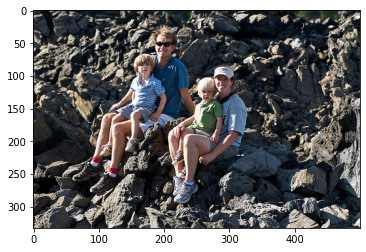

Captions
--------
Original 1: family sitting on rocks posing for the camera
Original 2: the couple have children sitting in their laps on the rocky hillside
Original 3: the four people sit on pile of rocks
Original 4: two adults and two children pose on pile of rocks
Original 5: two adults and two children sitting on rocks for picture
Generated : man in red shorts climbs rock with his arms raised

Evaluation
----------
BLEU(1) : 0.10000
BLEU(2) : 0.31623
BLEU(3) : 0.46416
BLEU(4) : 0.56234
METEOR  : 0.00847
ROUGE(1): 0.02222
ROUGE(2): 0.00000
ROUGE(3): 0.00000
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/354642192_3b7666a2dd.jpg


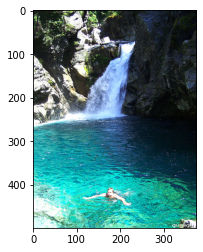

Captions
--------
Original 1: person floats in water near rocks and waterfall
Original 2: person swimming in pretty lake with waterfall in the background
Original 3: person swimming in water nearby rocks and small waterfall
Original 4: person swims in body of water with waterfall
Original 5: person swims in pool by waterfall
Generated : person in green swimsuit is just jumped into the water

Evaluation
----------
BLEU(1) : 0.40000
BLEU(2) : 0.63246
BLEU(3) : 0.73681
BLEU(4) : 0.79527
METEOR  : 0.29053
ROUGE(1): 0.35000
ROUGE(2): 0.00000
ROUGE(3): 0.00000
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/968081289_cdba83ce2e.jpg


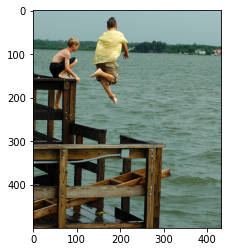

Captions
--------
Original 1: boy jumping off of dock while his friend watches
Original 2: two boys are climbing wooden platform and jumping into river
Original 3: two boys jumping off the pier into the water
Original 4: two boys preparing to jump off pier located on large body of water
Original 5: two children jump off the dock into the lake
Generated : two people are standing on the end of dock looking at the water and the water and mountains

Evaluation
----------
BLEU(1) : 0.57143
BLEU(2) : 0.27603
BLEU(3) : 0.42394
BLEU(4) : 0.52538
METEOR  : 0.07128
ROUGE(1): 0.31250
ROUGE(2): 0.04444
ROUGE(3): 0.00000
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/3482062809_3b694322c4.jpg


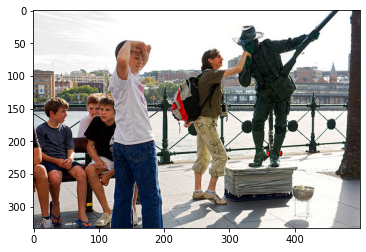

Captions
--------
Original 1: group of tourists stand around as lady puts her hand near the mouth of statue
Original 2: woman is making statue pretend to kiss her hand beside four boys at bench
Original 3: woman posing with statue alongside group of boys
Original 4: woman with backpack leans again statue while group of boys sit on bench talking
Original 5: woman gets her hand kissed by living statue street artist
Generated : woman in red shirt and brown pants is walking on the sidewalk

Evaluation
----------
BLEU(1) : 0.28216
BLEU(2) : 0.48872
BLEU(3) : 0.58692
BLEU(4) : 0.64319
METEOR  : 0.07018
ROUGE(1): 0.11667
ROUGE(2): 0.00000
ROUGE(3): 0.00000
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/1417031097_ab656bc4bd.jpg


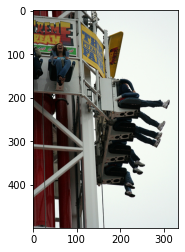

Captions
--------
Original 1: person is laughing on roller coaster ride
Original 2: photo of ride at an amusement park on an overcast day
Original 3: people are in ride that drops you from great height
Original 4: people on an amusement park ride
Original 5: people on ride at fair
Generated : man in red shirt is standing in front of large building

Evaluation
----------
BLEU(1) : 0.30000
BLEU(2) : 0.54772
BLEU(3) : 0.66943
BLEU(4) : 0.74008
METEOR  : -0.03680
ROUGE(1): 0.07895
ROUGE(2): 0.00000
ROUGE(3): 0.00000
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/302983277_69a4e732e4.jpg


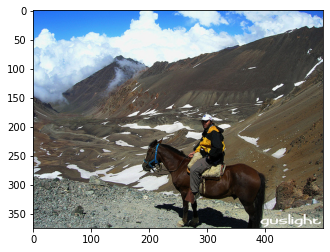

Captions
--------
Original 1: man in yellow jacket is riding horse through the mountains
Original 2: man rides horse while mountains and clouds are shown in the background
Original 3: man riding brown horse poses in front of mountain scene
Original 4: man sits on horse with mountains in the background
Original 5: man sitting on brown horse with mountains in background
Generated : man in red jacket is standing in front of mountain

Evaluation
----------
BLEU(1) : 0.77778
BLEU(2) : 0.65734
BLEU(3) : 0.47626
BLEU(4) : 0.35246
METEOR  : 0.22083
ROUGE(1): 0.30000
ROUGE(2): 0.11111
ROUGE(3): 0.05000
ROUGE(4): 0.02857



../../../datasets/image_captioning/flickr_8k/images/3514019869_7de4ece2a5.jpg


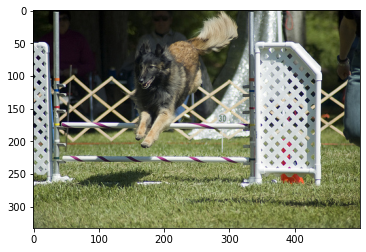

Captions
--------
Original 1: black and brown dog jumping over two white and purple stiped poles
Original 2: dog jumps over hurdle in the grass
Original 3: dog jumps over an obstacle
Original 4: black and brown dog jumping over hurdle with white supports
Original 5: dog performing during an outdoor dog show
Generated : dog jumps over hurdle

Evaluation
----------
BLEU(1) : 0.77880
BLEU(2) : 0.77880
BLEU(3) : 0.77880
BLEU(4) : 0.77880
METEOR  : 0.22133
ROUGE(1): 0.33333
ROUGE(2): 0.16667
ROUGE(3): 0.09677
ROUGE(4): 0.03846



../../../datasets/image_captioning/flickr_8k/images/1174629344_a2e1a2bdbf.jpg


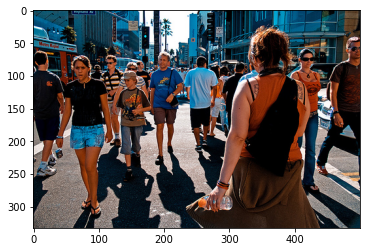

Captions
--------
Original 1: crowd of people walk down busy sidewalk
Original 2: group of different people are walking in all different directions in city
Original 3: group of people walking city street in warm weather
Original 4: busy intersection in the summer time in city
Original 5: people in summer clothes are walking on the sidewalk of large city
Generated : group of people are walking down street

Evaluation
----------
BLEU(1) : 1.00000
BLEU(2) : 0.81650
BLEU(3) : 0.64366
BLEU(4) : 0.71861
METEOR  : 0.32208
ROUGE(1): 0.37778
ROUGE(2): 0.16279
ROUGE(3): 0.05263
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/2991994415_504d1c0a03.jpg


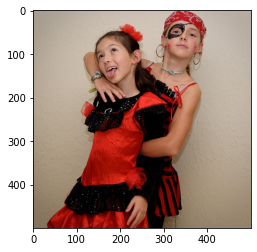

Captions
--------
Original 1: girl dressed in red dress and another girl dressed as pirate are playing around
Original 2: girls dressed in red and black costumes hold wrestling pose
Original 3: two girls dress up for halloween
Original 4: two girls in red costumes play together
Original 5: two little girls in red and black costumes are posing for picture
Generated : woman with her arms raised cut

Evaluation
----------
BLEU(1) : 1.00000
BLEU(2) : 1.00000
BLEU(3) : 1.00000
BLEU(4) : 1.00000
METEOR  : 0.00000
ROUGE(1): 0.00000
ROUGE(2): 0.00000
ROUGE(3): 0.00000
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/3217187564_0ffd89dec1.jpg


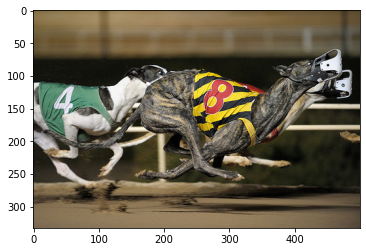

Captions
--------
Original 1: group of dogs racing
Original 2: number eight racing dog is beating number four racing dog slightly in race
Original 3: several dogs wearing muzzles are racing on track
Original 4: there are three dogs wearing numbered jerseys running race
Original 5: three race dogs run to finish race
Generated : dog is jumping over fence

Evaluation
----------
BLEU(1) : 0.40000
BLEU(2) : 0.31623
BLEU(3) : 0.46416
BLEU(4) : 0.56234
METEOR  : 0.01639
ROUGE(1): 0.05405
ROUGE(2): 0.02857
ROUGE(3): 0.00000
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/3024172109_a10198e1dd.jpg


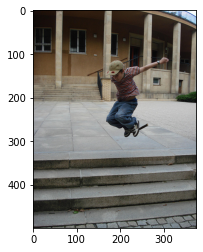

Captions
--------
Original 1: boy in baseball cap jumps over flight of stairs
Original 2: boy in striped shirt and hat does tricks on the steps
Original 3: boy wearing baseball cap jumps in the air near some steps
Original 4: young man jumping through the air near staircase
Original 5: there is boy wearing jeans and baseball cap jumping in the air
Generated : man in black shirt and jeans skateboards down street

Evaluation
----------
BLEU(1) : 0.55556
BLEU(2) : 0.26352
BLEU(3) : 0.41104
BLEU(4) : 0.51335
METEOR  : 0.12373
ROUGE(1): 0.17647
ROUGE(2): 0.02174
ROUGE(3): 0.00000
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/3472364264_dbde5a8d0a.jpg


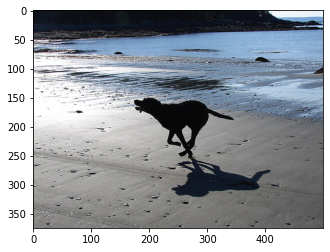

Captions
--------
Original 1: dog plays on the beach
Original 2: dog running on beach
Original 3: large dog runs on the beach with something hanging out of its mouth
Original 4: the dog ran across the beach
Original 5: the large black dog is running on the sand near the beach
Generated : black dog runs along the beach

Evaluation
----------
BLEU(1) : 0.83333
BLEU(2) : 0.70711
BLEU(3) : 0.79370
BLEU(4) : 0.84090
METEOR  : 0.32909
ROUGE(1): 0.43243
ROUGE(2): 0.17143
ROUGE(3): 0.00000
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/308487515_7852928f90.jpg


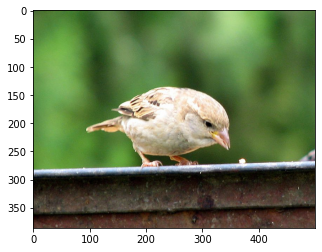

Captions
--------
Original 1: bird eating
Original 2: small pale bird bends down to examine crumb
Original 3: small white bird looks at small object
Original 4: tan bird stands on ledge about to eat something
Original 5: the bird leans over to small piece of food
Generated : man in red shirt is standing in front of group of people

Evaluation
----------
BLEU(1) : 0.10000
BLEU(2) : 0.31623
BLEU(3) : 0.46416
BLEU(4) : 0.56234
METEOR  : -0.06452
ROUGE(1): 0.02941
ROUGE(2): 0.00000
ROUGE(3): 0.00000
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/2511019188_ca71775f2d.jpg


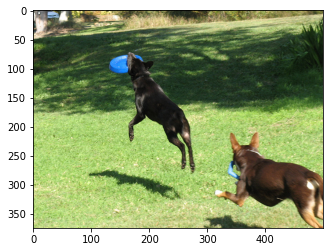

Captions
--------
Original 1: dog with frisbee in front of brown dog
Original 2: large black dog is catching frisbee while large brown dog follows shortly after
Original 3: two dark colored dogs romp in the grass with blue frisbee
Original 4: two dogs are catching blue frisbees in grass
Original 5: two dogs are playing one is catching frisbee
Generated : black dog is chasing after red ball

Evaluation
----------
BLEU(1) : 0.49536
BLEU(2) : 0.37834
BLEU(3) : 0.29169
BLEU(4) : 0.38298
METEOR  : -0.01238
ROUGE(1): 0.13333
ROUGE(2): 0.04651
ROUGE(3): 0.02632
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/3192069971_83c5a90b4c.jpg


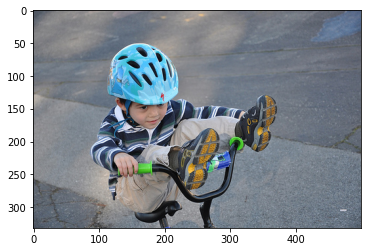

Captions
--------
Original 1: boy wearing blue helmet rides bike with his feet on the handlebars
Original 2: boy with blue helmet plays on his bicycle
Original 3: little boy with blue helmet rides his bike with his feet on the handlebars
Original 4: boy in blue helmet riding bike with feet on handlebars
Original 5: boy with helmet resting his feet on the handlebars of his bike
Generated : boy in helmet is riding scooter

Evaluation
----------
BLEU(1) : 0.47769
BLEU(2) : 0.26164
BLEU(3) : 0.36606
BLEU(4) : 0.43298
METEOR  : 0.15401
ROUGE(1): 0.22642
ROUGE(2): 0.01961
ROUGE(3): 0.00000
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/3655964639_21e76383d0.jpg


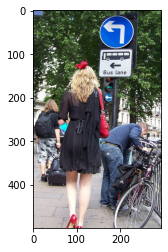

Captions
--------
Original 1: man chains his bike to rack while woman in black and red walks
Original 2: several people one being woman in black dress are outside near bike rack
Original 3: the woman wearing red bow walks past bicycle
Original 4: woman in black dress walking on the street
Original 5: woman in black dress with red accessories is walking down the street
Generated : man in red jacket and woman in black jacket stand by car

Evaluation
----------
BLEU(1) : 0.60000
BLEU(2) : 0.33029
BLEU(3) : 0.22178
BLEU(4) : 0.32318
METEOR  : 0.28411
ROUGE(1): 0.33333
ROUGE(2): 0.16327
ROUGE(3): 0.09091
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/2447284966_d6bbdb4b6e.jpg


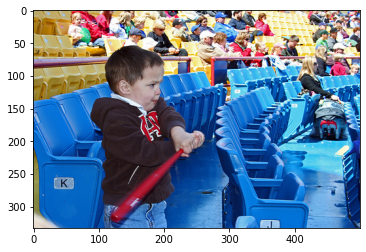

Captions
--------
Original 1: little boy is holding skinny baseball bat while standing between two rows of blue seats
Original 2: small boy dressed in black sweatshirt with logo on it holds red bat in front of blue stadium seats
Original 3: young boy in team sweatshirt is in sports stadium near blue seats swinging red bat
Original 4: young boy practices his bat swing while in the stands with blue seats
Original 5: the boy wearing black shirt and blue jeans is holding red baseball bat
Generated : two young boys are playing with plastic balls

Evaluation
----------
BLEU(1) : 0.20072
BLEU(2) : 0.32778
BLEU(3) : 0.38599
BLEU(4) : 0.41886
METEOR  : 0.03557
ROUGE(1): 0.06849
ROUGE(2): 0.00000
ROUGE(3): 0.00000
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/2602085456_d1beebcb29.jpg


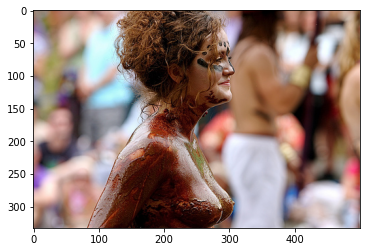

Captions
--------
Original 1: naked woman covered in mud in front of crowd
Original 2: naked woman covered in paint
Original 3: topless woman is covered in mud
Original 4: naked woman covered in mud in crowd
Original 5: topless woman smeared with brown substance blurry crowd in background
Generated : woman in red shirt and black hair is standing next to woman in black top

Evaluation
----------
BLEU(1) : 0.25000
BLEU(2) : 0.50000
BLEU(3) : 0.62996
BLEU(4) : 0.70711
METEOR  : 0.21463
ROUGE(1): 0.31429
ROUGE(2): 0.00000
ROUGE(3): 0.00000
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/537559285_29be110134.jpg


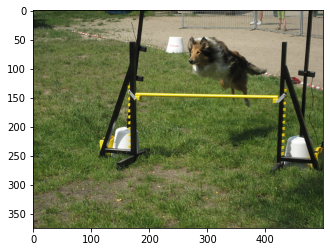

Captions
--------
Original 1: brown and white sheltie leaping over rail
Original 2: collie is running through an obstacle course
Original 3: collie jumping over training hurdle that is on the grass
Original 4: collie making jump over yellow hurdle
Original 5: the dog is leaping over hurdle
Generated : dog is jumping over hurdle

Evaluation
----------
BLEU(1) : 0.81873
BLEU(2) : 0.70904
BLEU(3) : 0.74387
BLEU(4) : 0.76191
METEOR  : 0.25688
ROUGE(1): 0.33333
ROUGE(2): 0.09677
ROUGE(3): 0.00000
ROUGE(4): 0.00000



../../../datasets/image_captioning/flickr_8k/images/766099402_cdda6964f0.jpg


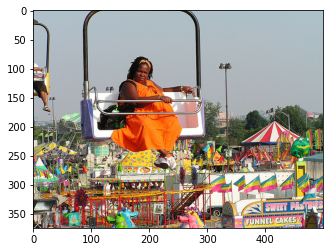

Captions
--------
Original 1: lady in an orange dress rides ride at the fair
Original 2: woman in an orange dress riding carnival ride
Original 3: woman sits alone at carnival in lift
Original 4: woman wearing an orange dress makes face while riding above the fair
Original 5: the woman is wearing an orange dress riding on the ferris wheel
Generated : man in red shirt is standing in front of some red building

Evaluation
----------
BLEU(1) : 0.20000
BLEU(2) : 0.44721
BLEU(3) : 0.58480
BLEU(4) : 0.66874
METEOR  : -0.20192
ROUGE(1): 0.08333
ROUGE(2): 0.00000
ROUGE(3): 0.00000
ROUGE(4): 0.00000





In [28]:
bleu_1 = BLEU(max_n_grams=1)
bleu_2 = BLEU(max_n_grams=2)
bleu_3 = BLEU(max_n_grams=3)
bleu_4 = BLEU(max_n_grams=4)
#cider = CIDEr(list([sent.replace('startseq', '').replace('endseq', '') for sent in train_descriptions.values()]))
cider = CIDEr(train_descriptions.values())
meteor = METEOR()
rouge = ROUGE_N()
spice = SPICE()

for z in range(600, 620):
    pic = list(encoding_test.keys())[z]
    references = test_descriptions[pic.split('.')[0]]
    if type(references[0]) == str:
        references = [reference.split() for reference in references]
    
    image = encoding_test[pic].reshape((1, OUTPUT_DIM))
    print(os.path.join(data_root, 'images', pic))
    x=plt.imread(os.path.join(data_root, 'images', pic))
    plt.imshow(x)
    plt.show()
    
    candidate = generateCaption(image).split()
    
    print("Captions")
    print("--------")
    for i in range(len(references)):
        print("Original %d:" %(i+1), ' '.join(references[i]))
    print("Generated :", ' '.join(candidate))
    
    print('')
    print("Evaluation")
    print("----------")
    print("BLEU(1) : %.5f" % bleu_1.score(references.copy(), [candidate.copy()]))
    print("BLEU(2) : %.5f" % bleu_2.score(references.copy(), [candidate.copy()]))
    print("BLEU(3) : %.5f" % bleu_3.score(references.copy(), [candidate.copy()]))
    print("BLEU(4) : %.5f" % bleu_4.score(references.copy(), [candidate.copy()]))
    #print("CIDEr  :", cider.score(references.copy(), candidate.copy()))
    print("METEOR  : %.5f" % np.mean([meteor.score(reference, candidate.copy()) for reference in references.copy()]))
    print("ROUGE(1): %.5f" % rouge.score(references.copy(), candidate.copy(), n_gram=1))
    print("ROUGE(2): %.5f" % rouge.score(references.copy(), candidate.copy(), n_gram=2))
    print("ROUGE(3): %.5f" % rouge.score(references.copy(), candidate.copy(), n_gram=3))
    print("ROUGE(4): %.5f" % rouge.score(references.copy(), candidate.copy(), n_gram=4))
    #print("SPICE   : %.5f" % spice.score([spice.clean(' '.join(reference)) for reference in references], spice.clean(' '.join(candidate))))
    print("\n\n")
    

encoding_test[pic].shape

### Evaluate Performance on My Own Photos 

In the "photos" folder of this GitHub repository I keep a collection of personal photos that I like to test neural networks on.  These are completly separate  dataset and as a result, the caption neural network does not perform nearly as well.

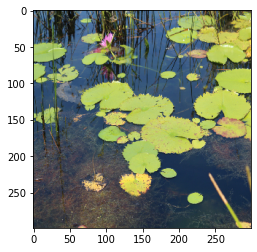

(1, 2048)
Caption: man in red shirt is standing in front of wooden boat
_____________________________________


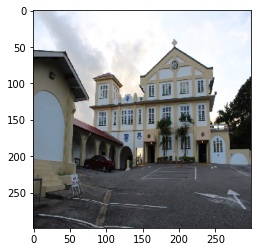

(1, 2048)
Caption: man in red shirt is standing in front of tent
_____________________________________


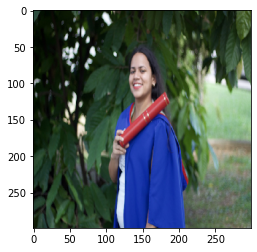

(1, 2048)
Caption: young boy wearing blue shirt is running through the grass
_____________________________________


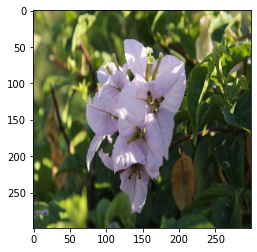

(1, 2048)
Caption: the little girl is holding green striped shirt
_____________________________________


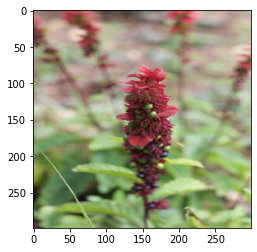

(1, 2048)
Caption: the little girl is holding colored striped baseball bat
_____________________________________


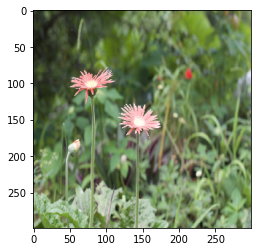

(1, 2048)
Caption: the little girl is holding green striped shirt
_____________________________________


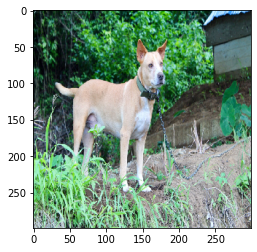

(1, 2048)
Caption: dog is running through tall grass
_____________________________________


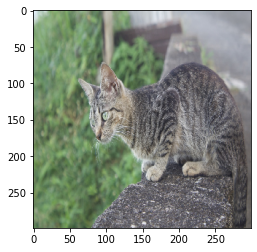

(1, 2048)
Caption: dog licks the end of someone
_____________________________________


In [29]:

%matplotlib inline

ids = [
  "1.jpeg", "2.jpeg", "3.jpeg", "4.jpeg", "5.jpeg", "6.jpeg", "7.jpeg", "8.jpeg"

]

for image_id in ids:
    image_path = os.path.join('./', 'test', image_id)
    images = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))

    plt.imshow(images)
    plt.show()

    images = encodeImage(images).reshape((1, OUTPUT_DIM))
    print(images.shape)
    print("Caption:", generateCaption(images))
    print("_____________________________________")

### Evaluate Performance on My Own Photos 

In the "photos" folder of this GitHub repository I keep a collection of personal photos that I like to test neural networks on.  These are completly separate from the Flicker8K dataset and as a result, the caption neural network does not perform nearly as well.

In [ ]:
%matplotlib inline

ids = [
  "1.jpeg", "2.jpeg", "3.jpeg", "4.jpeg", "5.jpeg", "6.jpeg", "7.jpeg", "8.jpeg"

]

for id in ids:
    image_path = os.path.join(data_root, 'test', id)
    images = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))

    plt.imshow(images)
    plt.show()

    images = encodeImage(images).reshape((1, OUTPUT_DIM))
    print(images.shape)
    print("Caption:", generateCaption(images))
    print("_____________________________________")